### Алгоритм Актор-Критик

Реализуем алгоритм Актор-Критик. Будем использовать две ИНС, одна для Актора, другая для Критика.

In [8]:
import gymnasium as gym
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import matplotlib.pyplot as plt
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# для избежания ошибки при отрисовки графиков

Пример архитектур ИНС для Актора и для Критика приведён ниже.

In [9]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution


class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        state_value = self.fc3(x)
        return state_value


Далее, реализуем класс агента.

In [10]:
class A2C_Agent():
    def __init__(self, env, actor, critic, alpha=0.01, gamma=0.99):
        # инициализация полей
        self.alpha = alpha
        self.gamma = gamma

        # инициализация ИНС и оптимизатора
        self.actor = actor
        self.critic = critic
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=self.alpha)
        self.optimizerC = optim.Adam(self.critic.parameters(), lr=self.alpha)
        # вектор для хранения логарифмов вероятностей
        self.log_probs = []
        self.values = []

    def reset(self):
        self.log_probs = []
        self.values = []        

    def get_action(self, state):
        state = torch.tensor(state).float()
        prob_distribution, value = actor(state), critic(state)
        action_tensor = prob_distribution.sample()
        
        log_prob = prob_distribution.log_prob(action_tensor).unsqueeze(0)
        self.log_probs.append(log_prob)
        self.values.append(value)

        action = action_tensor.item()
        return action
        
    def best_action(self, state):
        state = torch.tensor(state).float()
        with torch.no_grad():
            dist = actor(state)
            action_tensor = dist.sample()
            action = action_tensor.item()
            
        return action
    
    def update(self, rewards, last_state, terminated):
        last_state = torch.tensor(last_state).float()
        last_state_value = critic(last_state)

        R = (1-terminated)*last_state_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R 
            returns.insert(0, R)

        log_probs = torch.stack(self.log_probs)
        returns = torch.stack(returns).detach()
        values = torch.stack(self.values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        self.optimizerA.zero_grad()
        self.optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.optimizerA.step()
        self.optimizerC.step()

        self.log_probs = []
        self.values = []

    def play(self, env, n_episodes):
        for episode in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                action = agent.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break
             
    def save_model(self, fname):
        torch.save(self.actor, 'savedModels/' + fname +'_actor.pkl')
        torch.save(self.critic, 'savedModels/' + fname +'_critic.pkl')
        print('Saved: savedModels/' + fname +'_actor.pkl')
        print('Saved: savedModels/' + fname +'_critic.pkl')
        
    def load_model(self, fname):
        if os.path.exists('savedModels/' + fname +'_critic.pkl') and os.path.exists('savedModels/' + fname +'_actor.pkl'):
            self.critic = torch.load('savedModels/' + fname +'_critic.pkl', weights_only=False)
            self.actor = torch.load('savedModels/' + fname +'_actor.pkl', weights_only=False)
            print('Loaded')
        else:
            print("No such file")

In [11]:
def A2C_Control(env, agent, n_episodes=10000, goal_score=250):
    gains = []
    for i in range(n_episodes):
        state, _ = env.reset()
        rewards = []
        
        while True:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                    break

        agent.update(rewards, state, terminated)

        if i % 10 == 0:
            running_gain = np.mean(np.array(env.return_queue)[-50:])
            print("\rДоход: {:.2f} в эпизоде {}".format(running_gain, i))

        if running_gain > goal_score:
            print("Успех на эпизоде {}!".format(i))
            break

### Задача 1

Рассмотрим работу алгоритма A2C на задаче об обратном маятнике.

In [12]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution


class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        state_value = self.fc2(x)
        return state_value

In [18]:
env = gym.make("CartPole-v1", max_episode_steps = 500)
env = gym.wrappers.RecordEpisodeStatistics(env,2000)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n


actor = Actor(state_size, action_size)
critic = Critic(state_size)

agent = A2C_Agent(env, actor, critic, alpha = 0.01)
state, _ = env.reset()
state
agent.best_action(state)

0

In [20]:
gains = A2C_Control(env, agent, n_episodes=500, goal_score=450)

Доход: 42.00 в эпизоде 0
Доход: 23.09 в эпизоде 10
Доход: 32.43 в эпизоде 20
Доход: 36.26 в эпизоде 30
Доход: 39.85 в эпизоде 40
Доход: 46.42 в эпизоде 50
Доход: 58.00 в эпизоде 60
Доход: 77.88 в эпизоде 70
Доход: 112.88 в эпизоде 80
Доход: 160.38 в эпизоде 90
Доход: 244.88 в эпизоде 100
Доход: 312.88 в эпизоде 110
Доход: 382.00 в эпизоде 120
Доход: 438.14 в эпизоде 130
Доход: 480.44 в эпизоде 140
Успех на эпизоде 140!


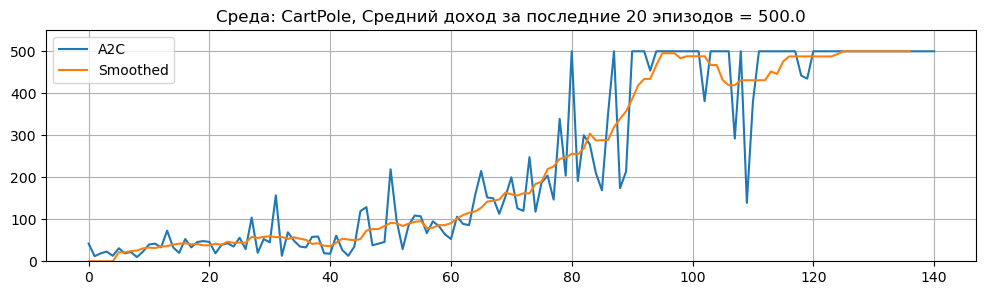

In [22]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(0, 550)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("CartPole", returns, 'A2C')

In [43]:
agent.save_model('A2C_2NN_CartPole_64neurons')

Saved: savedModels/A2C_2NN_CartPole_64neurons_actor.pkl
Saved: savedModels/A2C_2NN_CartPole_64neurons_critic.pkl


In [33]:
agent.load_model('A2C_2NN_CartPole_64neurons')

Loaded


In [24]:
env = gym.make('CartPole-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, 100)
agent.play(env,100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.49it/s]

Средний доход:  496.71
Минимальный доход:  171.0


### Задача 2

Применим метод A2C к задаче о лунном модуле.

In [26]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob_distribution = Categorical(F.softmax(x, dim=-1))
        return prob_distribution


class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 96)
        self.fc2 = nn.Linear(96, 96)
        self.fc3 = nn.Linear(96, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        state_value = self.fc3(x)
        return state_value

In [28]:
env = gym.make("LunarLander-v3")  
env = gym.wrappers.RecordEpisodeStatistics(env,2000)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

actor = Actor(state_size, action_size)
critic = Critic(state_size)

agent = A2C_Agent(env, actor, critic, alpha = 0.001, gamma = 0.99)
state, _ = env.reset()
state
agent.best_action(state)

1

In [58]:
gains = A2C_Control(env, agent, n_episodes=2000, goal_score=180)

Доход: -102.33 в эпизоде 0
Доход: -181.64 в эпизоде 10
Доход: -177.13 в эпизоде 20
Доход: -183.46 в эпизоде 30
Доход: -170.19 в эпизоде 40
Доход: -173.54 в эпизоде 50
Доход: -176.55 в эпизоде 60
Доход: -178.87 в эпизоде 70
Доход: -178.68 в эпизоде 80
Доход: -172.75 в эпизоде 90
Доход: -165.06 в эпизоде 100
Доход: -150.60 в эпизоде 110
Доход: -134.17 в эпизоде 120
Доход: -129.90 в эпизоде 130
Доход: -135.74 в эпизоде 140
Доход: -146.97 в эпизоде 150
Доход: -143.46 в эпизоде 160
Доход: -145.77 в эпизоде 170
Доход: -141.91 в эпизоде 180
Доход: -150.19 в эпизоде 190
Доход: -137.06 в эпизоде 200
Доход: -139.68 в эпизоде 210
Доход: -139.33 в эпизоде 220
Доход: -130.19 в эпизоде 230
Доход: -116.12 в эпизоде 240
Доход: -112.54 в эпизоде 250
Доход: -111.61 в эпизоде 260
Доход: -110.82 в эпизоде 270
Доход: -106.86 в эпизоде 280
Доход: -113.71 в эпизоде 290
Доход: -110.89 в эпизоде 300
Доход: -99.48 в эпизоде 310
Доход: -100.40 в эпизоде 320
Доход: -104.65 в эпизоде 330
Доход: -103.43 в эпизоде 3

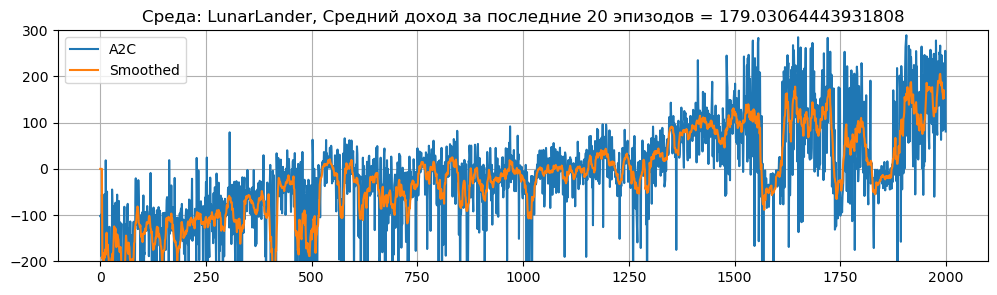

In [60]:
def plot_rewards(env_name, returns, label):
    # сглаженный вектор доходов
    returns_smoothed = np.pad(np.convolve(returns, np.ones(10)/10, mode='valid'),[5, 0])
    fig = plt.figure(figsize=(12, 3))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.plot(returns_smoothed, label="Smoothed")
    plt.grid()
    plt.legend()
    plt.ylim(-200, 300)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("LunarLander", returns, 'A2C')

In [62]:
agent.save_model('A2C_2NN_LunarLander')

Saved: savedModels/A2C_2NN_LunarLander_actor.pkl
Saved: savedModels/A2C_2NN_LunarLander_critic.pkl


In [29]:
agent.optimizerA = optim.Adam(agent.actor.parameters(), lr=0.0005)
agent.optimizerC = optim.Adam(agent.critic.parameters(), lr=0.0002)

In [30]:
gains = A2C_Control(env, agent, num_episodes=2500, goal_score=225)

Эпизод: 0, Средний доход за 100 эпизодов: 137.0536408914524
Эпизод: 10, Средний доход за 100 эпизодов: 96.51514683511746
Эпизод: 20, Средний доход за 100 эпизодов: 87.34236547063529
Эпизод: 30, Средний доход за 100 эпизодов: 89.99727480114342
Эпизод: 40, Средний доход за 100 эпизодов: 96.6549995379805
Эпизод: 50, Средний доход за 100 эпизодов: 102.4804229678268
Эпизод: 60, Средний доход за 100 эпизодов: 108.98375070476904
Эпизод: 70, Средний доход за 100 эпизодов: 114.3027923211265
Эпизод: 80, Средний доход за 100 эпизодов: 118.56004070390651
Эпизод: 90, Средний доход за 100 эпизодов: 119.33697895705357
Эпизод: 100, Средний доход за 100 эпизодов: 121.03893140911039
Эпизод: 110, Средний доход за 100 эпизодов: 124.64772788522325
Эпизод: 120, Средний доход за 100 эпизодов: 130.28488354360496
Эпизод: 130, Средний доход за 100 эпизодов: 136.09042671978702
Эпизод: 140, Средний доход за 100 эпизодов: 136.21908365434746
Эпизод: 150, Средний доход за 100 эпизодов: 136.47004639721217
Эпизод: 160